**Prepared By:**
KSU Student
Maha Alrowaitie

Shekha Alabdulsalam

Lina Alrabeah


Basma Alamoud






# **Portfolio Optimization Probelm**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

BUDGET = 0
N = 0
RISK_RATE = 0
EXP_RETURNS = []
COV_MATRIX = []

def ReadInputs(filePath):
    global N, BUDGET, RISK_RATE, EXP_RETURNS, COV_MATRIX
    with open(filePath, 'r') as file:
        BUDGET = float(file.readline().strip())
        N = int(file.readline().strip())
        RISK_RATE = float(file.readline().strip())
        EXP_RETURNS = list(map(float, file.readline().split()))
        COV_MATRIX = [list(map(float, file.readline().split())) for _ in range(N)]


def RandomSolution():
    weights = np.random.rand(N)
    weights = weights / np.sum(weights)
    weights = np.round(weights, decimals=4)
    weights[-1] = 1 - np.sum(weights[:-1])
    return weights


def RepairSolution(solution):
    solution = np.abs(solution)
    solution = solution / np.sum(solution)
    solution = np.round(solution, decimals=4)
    solution[-1] = 1 - np.sum(solution[:-1])
    return solution


def ComputeFitness(solution) -> float:
    portfolioReturn = np.sum(np.multiply(solution, EXP_RETURNS))
    portfolioRiskSquared = np.dot(np.dot(solution, COV_MATRIX), solution)
    portfolioRisk = portfolioRiskSquared ** 0.5
    fitness_value = (portfolioReturn - RISK_RATE) / portfolioRisk
    return fitness_value


def GenerateNeighbor(solution):
    neighbor = solution.copy()
    neighbor [-1] = 1 - neighbor[-1]
    neighbor = RepairSolution(neighbor)
    return neighbor


class LocalSearch:
    def __init__(self) -> None:
        self.ResetCounter = 3
        self.Evaluations = 10000
        self.solution = RandomSolution()
        self.maxFitness = ComputeFitness(self.solution)

    def SetMaximum(self, solution, fitness):
        if fitness > self.maxFitness:
            self.solution = solution
            self.maxFitness = fitness

    def Run(self):
        equalCount = 0
        fitness_values = []
        while self.Evaluations > 0:
            neighbor = GenerateNeighbor(self.solution)
            neighbor_fitness = ComputeFitness(neighbor)
            self.Evaluations -= 1

            self.SetMaximum(neighbor, neighbor_fitness)
            fitness_values.append(self.maxFitness)

            if abs(neighbor_fitness - self.maxFitness) < 1e-7:
                equalCount += 1
            else:
                equalCount = 0
            if equalCount >= self.ResetCounter:
                current_solution = RandomSolution()
                current_fitness = ComputeFitness(current_solution)
                self.SetMaximum(current_solution, current_fitness)
                self.Evaluations -= 1
                equalCount = 0

        return fitness_values


class GeneticAlgorithm:
    def __init__(self, populationSize, EnableCrossover, MutationOp, evaluations=10000) -> None:
        self.evaluations = evaluations
        self.EnableCrossover = EnableCrossover
        self.MutationOp = MutationOp
        self.populationSize = populationSize
        self.solution = []
        self.maxFitness = 0
        self.population = []
        self.fitnesses = []
        self.generation = 0
        self.best_fitness_history = []
        self.CreateInitialPopulation()

    def CreateInitialPopulation(self):
        for _ in range(self.populationSize):
            solution = RandomSolution()
            self.population.append(solution)
            fitness = ComputeFitness(solution)
            self.evaluations -= 1
            self.fitnesses.append(fitness)

    def BinaryTournament(self) -> int:
        index1 = np.random.randint(0, self.populationSize)
        index2 = np.random.randint(0, self.populationSize)
        mx = index1 if self.fitnesses[index1] > self.fitnesses[index2] else index2
        return mx

    def Crossover(self, parent1, parent2):
        if not self.EnableCrossover:
            return parent1, parent2
        crossover_point = np.random.randint(1, N)
        offspring1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        offspring2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        return offspring1, offspring2

    def Mutation(self, solution):
        mutated_solution = solution.copy()
        if self.MutationOp is not None:
            for _ in range(self.MutationOp):
                gene_index = np.random.randint(0, N)
                mutated_solution[gene_index] = np.random.rand()
        return mutated_solution

    def WeakestReplacement(self, offspring, offspring_fitness):
        weakest_index = np.argmin(self.fitnesses)
        if offspring_fitness > self.fitnesses[weakest_index]:
            self.fitnesses[weakest_index] = offspring_fitness
            self.population[weakest_index] = offspring

    def Run(self):
        while self.evaluations > 0:
            a = self.BinaryTournament()
            b = self.BinaryTournament()
            parent1 = self.population[a]
            parent2 = self.population[b]

            offspring1, offspring2 = self.Crossover(parent1, parent2)

            offspring1 = self.Mutation(offspring1)
            offspring2 = self.Mutation(offspring2)

            offspring1 = RepairSolution(offspring1)
            offspring2 = RepairSolution(offspring2)

            offspring1_fitness = ComputeFitness(offspring1)
            offspring2_fitness = ComputeFitness(offspring2)
            self.evaluations -= 2

            self.WeakestReplacement(offspring1, offspring1_fitness)
            self.WeakestReplacement(offspring2, offspring2_fitness)

            mxIndex = np.argmax(self.fitnesses)
            best_fitness = self.fitnesses[mxIndex]
            self.best_fitness_history.append(best_fitness)

            self.generation += 1

        best_solution_index = np.argmax(self.fitnesses)
        best_solution = self.population[best_solution_index]
        return self.best_fitness_history, best_solution


if __name__ == '__main__':
    ReadInputs('input2.txt')

    # Local Search
    LS_results = {'solutions': [], 'fitness_values': []}
    for i in range(5):
        LS = LocalSearch()
        np.random.seed(i)
        fitness_values = LS.Run()
        LS_results['solutions'].append(LS.solution)
        LS_results['fitness_values'].append(fitness_values)

    print("Local Search:")
    for i, solution in enumerate(LS_results['solutions']):
        print(f"\t-Solution {i + 1}:", solution)
        print(f"\t-Fitness {i + 1}:", LS_results['fitness_values'][i][-1])
        print("\n")

    print('*********************************************************************************')
    best_ls_index = np.argmax([fitness[-1] for fitness in LS_results['fitness_values']])
    print("\nBest Local Search Solution:")
    print(f"\t-Best Solution:", LS_results['solutions'][best_ls_index])
    print(f"\t-Best Fitness:", LS_results['fitness_values'][best_ls_index][-1])

    print("\n" + "=" * 50 + "\n")

    # Genetic Algorithm
    GA_experiments = [
        {'populationSize': 10, 'EnableCrossover': True, 'MutationOp': 1},
        {'populationSize': 100, 'EnableCrossover': True, 'MutationOp': 1},
        {'populationSize': 10, 'EnableCrossover': True, 'MutationOp': 5},
        {'populationSize': 100, 'EnableCrossover': True, 'MutationOp': 5},
        {'populationSize': 10, 'EnableCrossover': False, 'MutationOp': 5},
        {'populationSize': 10, 'EnableCrossover': True, 'MutationOp': None}
    ]

    GA_results = {'solutions': [], 'fitness_values': [], 'best_fitness_history': []}
for exp_index, exp in enumerate(GA_experiments):
    populationSize = exp['populationSize']
    EnableCrossover = exp['EnableCrossover']
    MutationOp = exp['MutationOp']

    for trial in range(5):
        GA = GeneticAlgorithm(populationSize, EnableCrossover, MutationOp)
        best_fitness_history, best_solution = GA.Run()
        GA_results['solutions'].append(best_solution)
        GA_results['fitness_values'].append(best_fitness_history)
        GA_results['best_fitness_history'].append(GA.best_fitness_history)
        print('--------------------')
        print(f"GA Experiment {exp_index + 1}/{len(GA_experiments)} - Population Size: {populationSize}, Crossover: {'Single-Point' if EnableCrossover else 'None'}, Mutation: {'M1' if MutationOp == 1 else 'M5' if MutationOp == 5 else 'None'}, Trial: {trial + 1}")
        print(f"\t- Solution: {best_solution}")
        print(f"\t- Fitness: {best_fitness_history[-1]}\n")

print('*********************************************************************************')
best_ga_index = np.argmax([fitness[-1] for fitness in GA_results['fitness_values']])
print("\nBest Genetic Algorithm Solution:")
print(f"\t-Best Solution:", GA_results['solutions'][best_ga_index])
print(f"\t-Best Fitness:", GA_results['fitness_values'][best_ga_index][-1])


Local Search:
	-Solution 1: [0.1595 0.1618 0.112  0.0776 0.1197 0.05   0.008  0.1386 0.0977 0.0751]
	-Fitness 1: -1.2915032390761476


	-Solution 2: [0.0891 0.1161 0.0979 0.0885 0.0688 0.1049 0.0711 0.1448 0.1565 0.0623]
	-Fitness 2: -1.2212795001239327


	-Solution 3: [0.1325 0.2289 0.     0.0961 0.0466 0.0293 0.0592 0.1098 0.1261 0.1715]
	-Fitness 3: -1.4689600240002303


	-Solution 4: [0.1215 0.0072 0.1532 0.1213 0.1172 0.0921 0.057  0.1726 0.0835 0.0744]
	-Fitness 4: -1.0221038396010182


	-Solution 5: [0.1178 0.1515 0.0622 0.1093 0.191  0.1917 0.0269 0.0443 0.011  0.0943]
	-Fitness 5: -2.2997739149877794


*********************************************************************************

Best Local Search Solution:
	-Best Solution: [0.1215 0.0072 0.1532 0.1213 0.1172 0.0921 0.057  0.1726 0.0835 0.0744]
	-Best Fitness: -1.0221038396010182


--------------------
GA Experiment 1/6 - Population Size: 10, Crossover: Single-Point, Mutation: M1, Trial: 1
	- Solution: [7.000e-04 7.000e-04

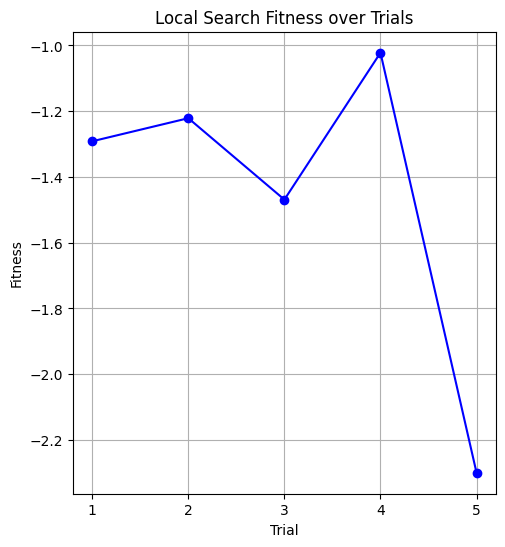

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Fitness values
ls_fitness_values = [fitness[-1] for fitness in LS_results['fitness_values']]
ga_fitness_values = [fitness[-1] for fitness in GA_results['fitness_values']]

# Number of trials
ls_trials = list(range(1, len(ls_fitness_values) + 1))
ga_trials = list(range(1, len(ga_fitness_values) + 1))

# Plotting graphs with gridspec
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])  # 1 row, 2 columns

# Plotting Local Search Fitness
ax0 = plt.subplot(gs[0])
ax0.plot(ls_trials, ls_fitness_values, marker='o', linestyle='-', color='b')
ax0.set_title('Local Search Fitness over Trials')
ax0.set_xlabel('Trial')
ax0.set_ylabel('Fitness')
ax0.set_xticks(ls_trials)
ax0.grid(True)


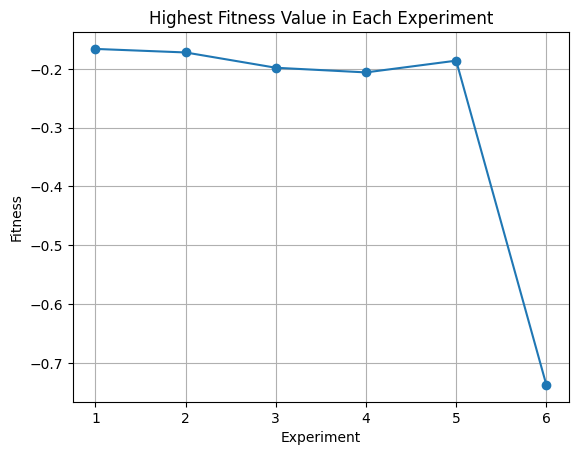

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Extract the highest fitness value from each experiment
highest_fitness_values = []
for i in range(0, len(GA_results['fitness_values']), 5):
    experiment_fitness = GA_results['fitness_values'][i:i+5]
    max_fitness = max(np.max(experiment_fitness, axis=1))
    highest_fitness_values.append(max_fitness)

# Plot the graph
plt.plot(range(1, 7), highest_fitness_values, marker='o')
plt.xlabel('Experiment')
plt.ylabel('Fitness')
plt.title('Highest Fitness Value in Each Experiment')
plt.xticks(range(1, 7))
plt.grid(True)
plt.show()


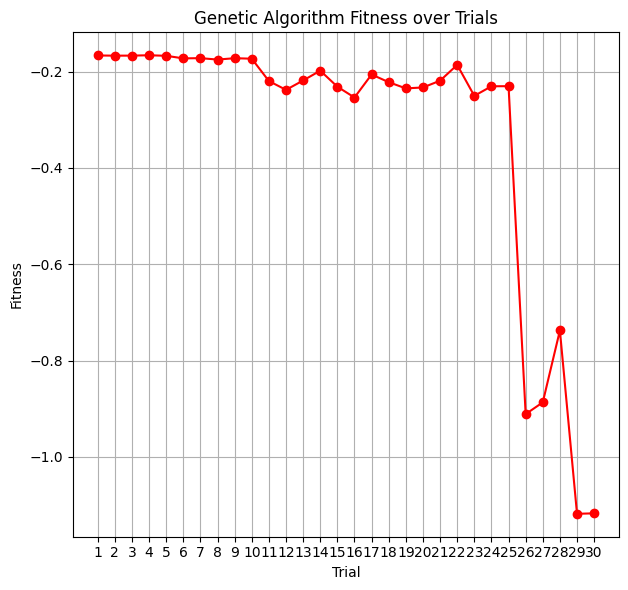

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Fitness values
ga_fitness_values = [fitness[-1] for fitness in GA_results['fitness_values']]

# Number of trials
ga_trials = list(range(1, len(ga_fitness_values) + 1))

# Plotting graphs with gridspec
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])  # 1 row, 2 columns


# Plotting Genetic Algorithm Fitness
ax1 = plt.subplot(gs[1])
ax1.plot(ga_trials, ga_fitness_values, marker='o', linestyle='-', color='r')
ax1.set_title('Genetic Algorithm Fitness over Trials')
ax1.set_xlabel('Trial')
ax1.set_ylabel('Fitness')
ax1.set_xticks(ga_trials)
ax1.grid(True)

plt.tight_layout()
plt.show()


Local search converges towards solutions with fitness values ranging from -1.02 to -2.29, indicating a diverse range of asset allocations that carefully balance risk and return considerations. In contrast, the Genetic Algorithm exhibits significant variability across trials, emphasizing the influence of parameters such as population size, crossover, and mutation strategies. The most successful Genetic Algorithm configuration consistently achieves a fitness of approximately -0.166, utilizing a population size of 10, single-point crossover, and one-point mutation. This underscores the algorithm's sensitivity to parameter settings, with specific configurations consistently delivering superior results. Overall, the Genetic Algorithm demonstrates notable performance compared to Local Search in achieving optimal fitness values, showcasing its efficacy in navigating the intricate search space of portfolio optimization.





